# Comparing the deflection due to different geometric models

In [1]:
# Necessary imports 
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy.optimize as op
from IPython.display import Image
%matplotlib inline

In [2]:
# Function to calculate fret positions and frequencies
def calc_vibelen_freq(scaleLength_m, nFrets=18, freqOpen_Hz=440.0, 
                      nutOffset_m=0.0, saddleOffset_m=0.0, verbose=False):
    """
    Return arrays of vibrating string length and frequency for an ideal
    instrument given a scale length. In the arrays returned, the 1st
    entry [0] is the nut and the last entry [nFrets + 1] is the saddle.
    """
    
    # Calculate the ideal vibrating length from each fret to saddle
    fretIndxArr = np.arange(nFrets + 2)
    vibeLenArr_m = scaleLength_m / (2**(fretIndxArr / 12))
    vibeLenArr_m[0] += nutOffset_m
    vibeLenArr_m += saddleOffset_m
    vibeLenArr_m[-1] = 0.0
    
    # Calculate the fundamental frequency at each fret
    with np.errstate(divide='ignore', invalid='ignore'):
        freqArr_Hz = freqOpen_Hz * vibeLenArr_m[0] / vibeLenArr_m
    
    # Calculate the distance from the nut
    distNutArr_m = vibeLenArr_m[0] - vibeLenArr_m
    
    # Print the values if verbose flag set
    if verbose:
        print("Fret  Nut_Distance  Vibrate_Length  Frequency")
        print("              (mm)            (mm)       (Hz)")
        print("-" * 50)
        for i in range(len(distNutArr_m)):
            print(" {:2d}: {:13.1f} {:15.1f} {:10.2f}".format(
                i, distNutArr_m[i]*1000, vibeLenArr_m[i]*1000, freqArr_Hz[i]))
            
    return vibeLenArr_m, freqArr_Hz

In [3]:
# Geometric parameters of a ukulele
nFrets =               18
scaleLength_m =     420.0 / 1000
actionNut_m  =        1.5 / 1000
actionFret12_m =      3.5 / 1000
fingerWidth_m =       5.0 / 1000
fretHeight_m =        1.0 / 1000

# Player strength parameters
depressHeight_m =     0.5 / 1000
depressMod =          0.2

# String specific parameters
freqOpen_Hz =       440.0
massPerLength_kgm =  1e-4
stringDiameter_m =    0.5 / 1000
elasticity_Pa =       4e9
nutOffset_m =         0.0 / 1000
saddleOffset_m =      0.0 / 1000

In [4]:
# Calculate the ideal fret positions and frequency array
vibeLenIdealArr_m, freqIdealArr_Hz = calc_vibelen_freq(
    scaleLength_m=scaleLength_m,
    nFrets=nFrets,
    freqOpen_Hz=freqOpen_Hz,
    verbose=True)

Fret  Nut_Distance  Vibrate_Length  Frequency
              (mm)            (mm)       (Hz)
--------------------------------------------------
  0:           0.0           420.0     440.00
  1:          23.6           396.4     466.16
  2:          45.8           374.2     493.88
  3:          66.8           353.2     523.25
  4:          86.6           333.4     554.37
  5:         105.4           314.6     587.33
  6:         123.0           297.0     622.25
  7:         139.7           280.3     659.26
  8:         155.4           264.6     698.46
  9:         170.3           249.7     739.99
 10:         184.3           235.7     783.99
 11:         197.5           222.5     830.61
 12:         210.0           210.0     880.00
 13:         221.8           198.2     932.33
 14:         232.9           187.1     987.77
 15:         243.4           176.6    1046.50
 16:         253.3           166.7    1108.73
 17:         262.7           157.3    1174.66
 18:         271.5           

## Model 1: Simple Clothesline

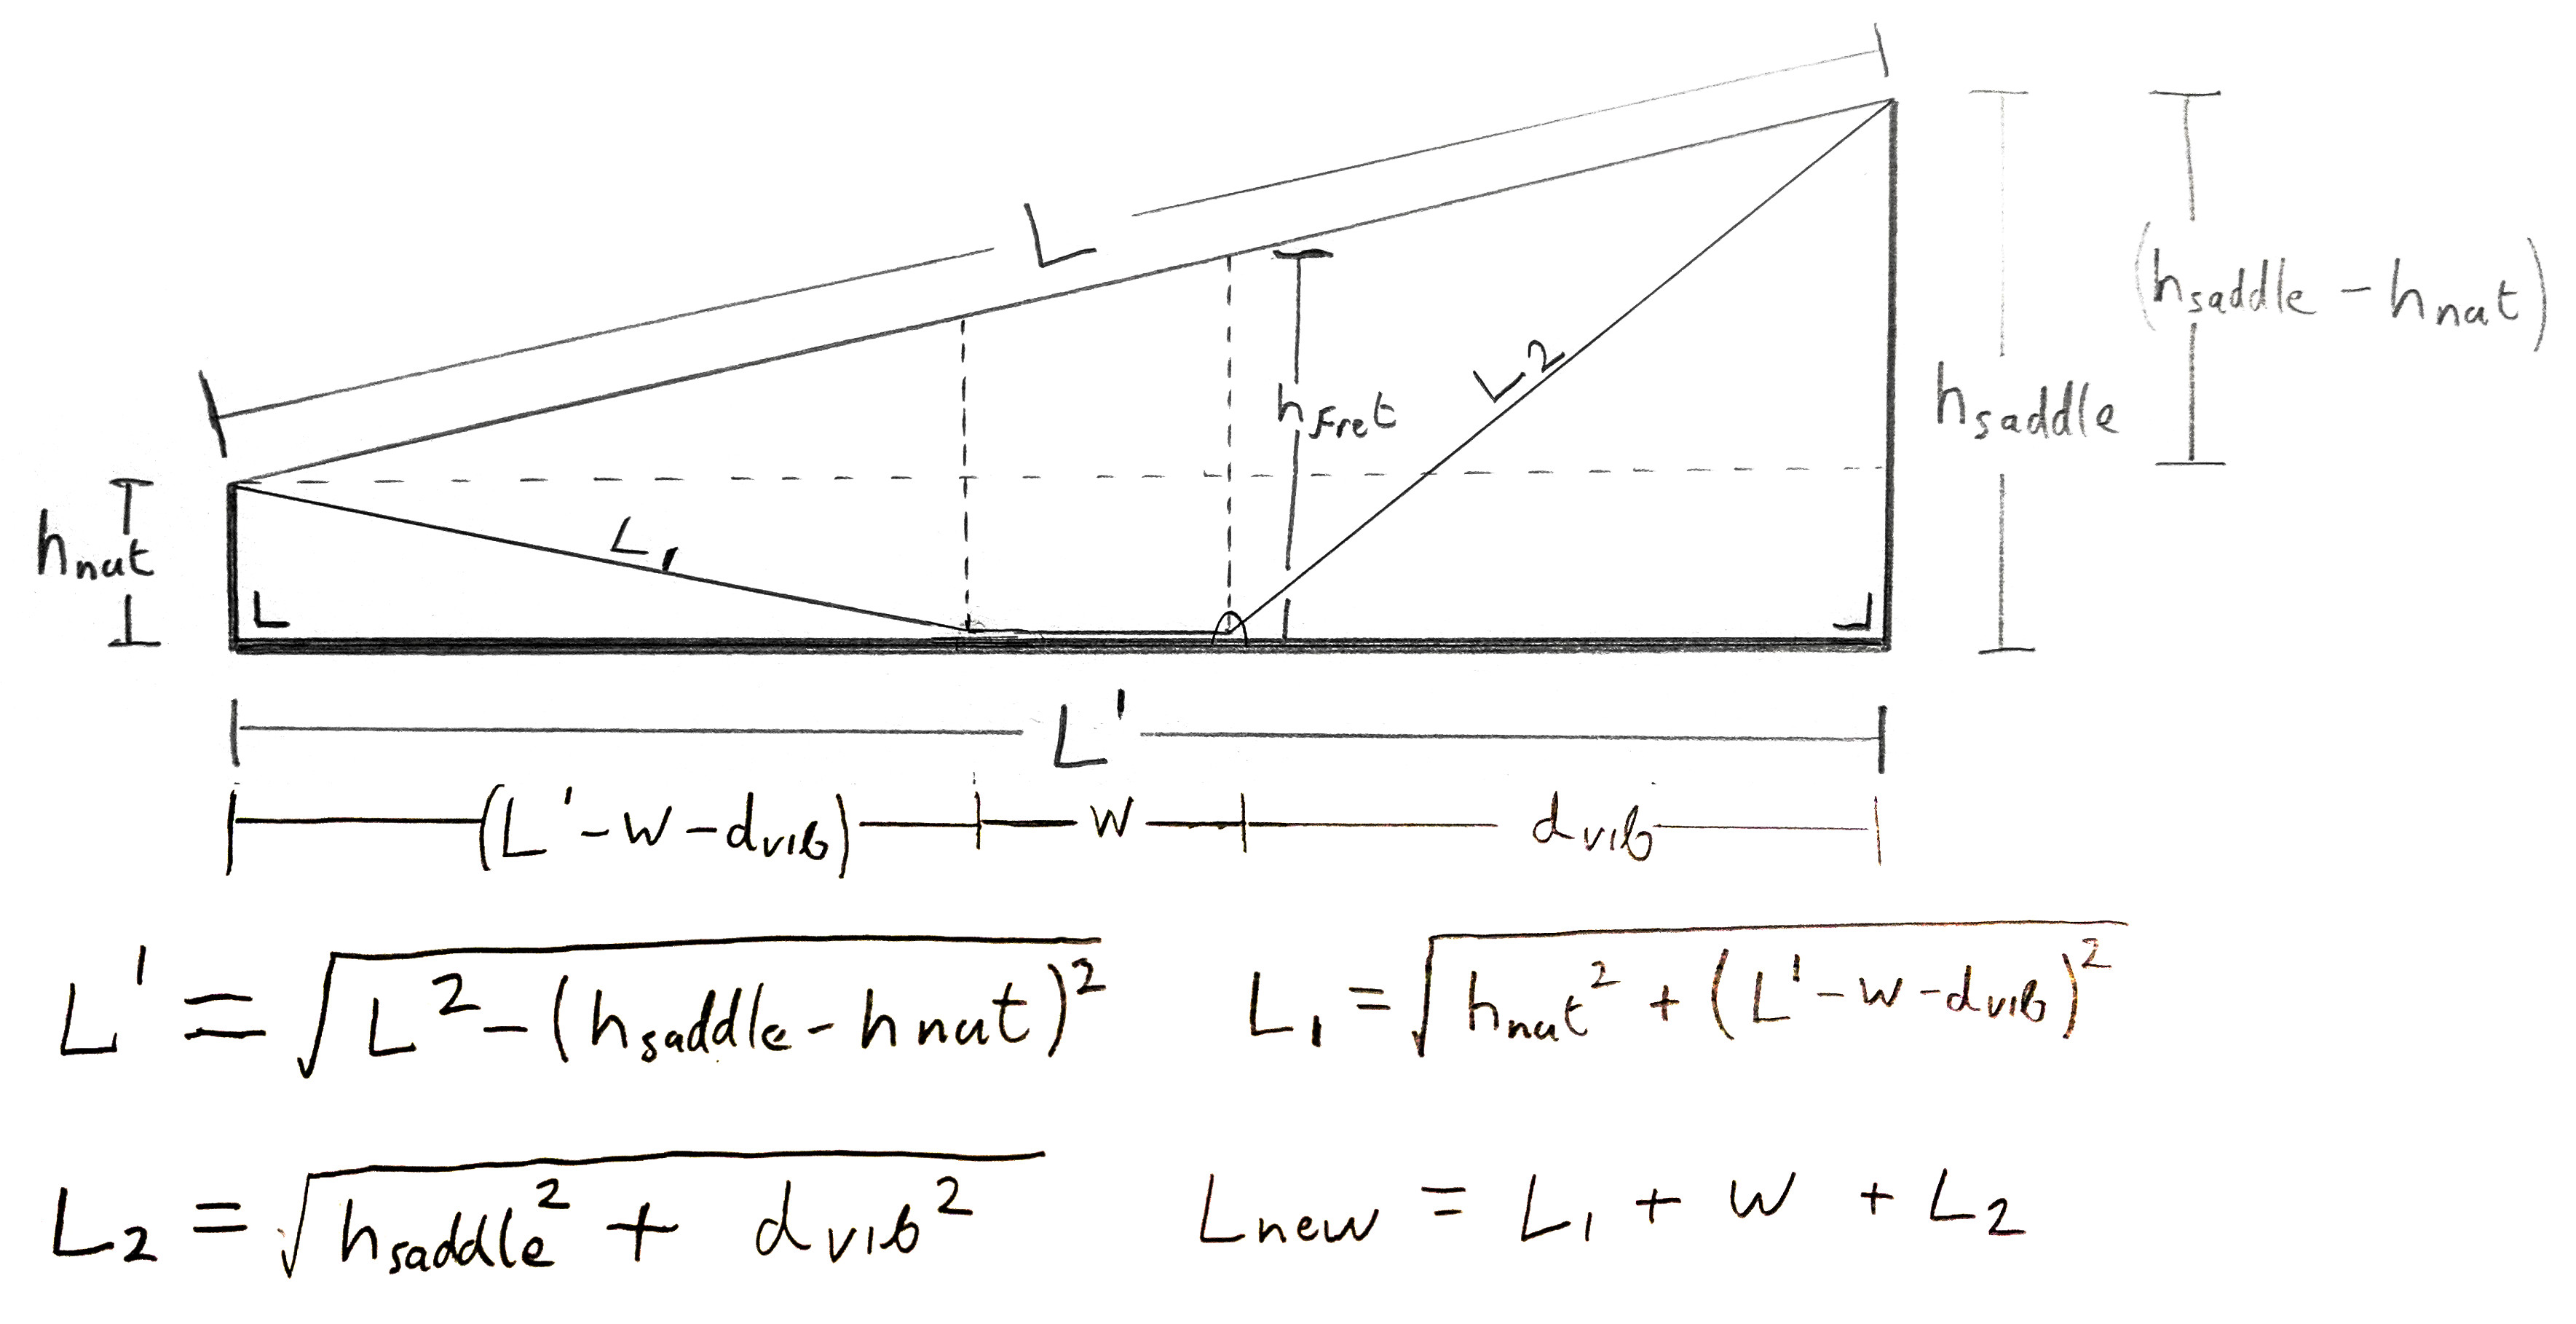

In [5]:
Image("Images/simple_clothesline.jpeg")

In [6]:
# Model 1
def model1(vibeLenArr, actionNut=1.5/1000, actionFret12=3.5/1000,
           fingerWidth=7.0/1000, verbose=False):
    """
    Return an array of total (i.e., open) string lengths 
    corresponding to the string being depressed behind each fret.
    """    
    
    # Calculate the slope of the open string and action at saddle
    x1 = vibeLenArr[12]
    x2 = vibeLenArr[0]
    y1 = actionFret12
    y2 = actionNut
    m = (y2 - y1) / (x2 - x1)
    actionSaddle = actionFret12 - m * vibeLenArr[12]
    
    # Calculate Lproj: the length of the string projected to the fingerboard
    Lproj = vibeLenArr[0]
    Lopen = np.sqrt(vibeLenArr[0]**2.0 + (actionSaddle - actionNut)**2.0)
    
    # Calculate the clipped finger width if the finger overlaps previous fret
    fretWidthArr = np.zeros_like(vibeLenArr)
    fretWidthArr[1:] = -1 * np.diff(vibeLenArr)
    fingerWidthArr = np.where(fretWidthArr <= fingerWidth, fretWidthArr, fingerWidth)
    fingerWidthArr[-1] = 0
    
    # Calculate L1, the string length above the finger press
    L1 = np.sqrt(actionNut**2.0 + (Lproj - fingerWidthArr - vibeLenArr)**2.0)
    #print(L1)
    
    # Calculate L2, the string length below the finger press
    L2 = np.sqrt(actionSaddle**2.0 + vibeLenArr**2.0)

    # Deflected length: nut-to-finger + fingerWidth + fret-to-saddle
    # Set the nut to the open length and saddle to np.nan
    newLArr = L1 + fingerWidthArr + L2
    newLArr[0] = Lopen
    newLArr[-1] = np.nan
    
    # Some feedback
    if verbose:
        print("Saddle Action    = {:6.2f}".format(actionSaddle))
        print("Projected Length = {:6.2f}".format(Lproj))
    
    return newLArr

## Model 2: Clothesline with sharp finger

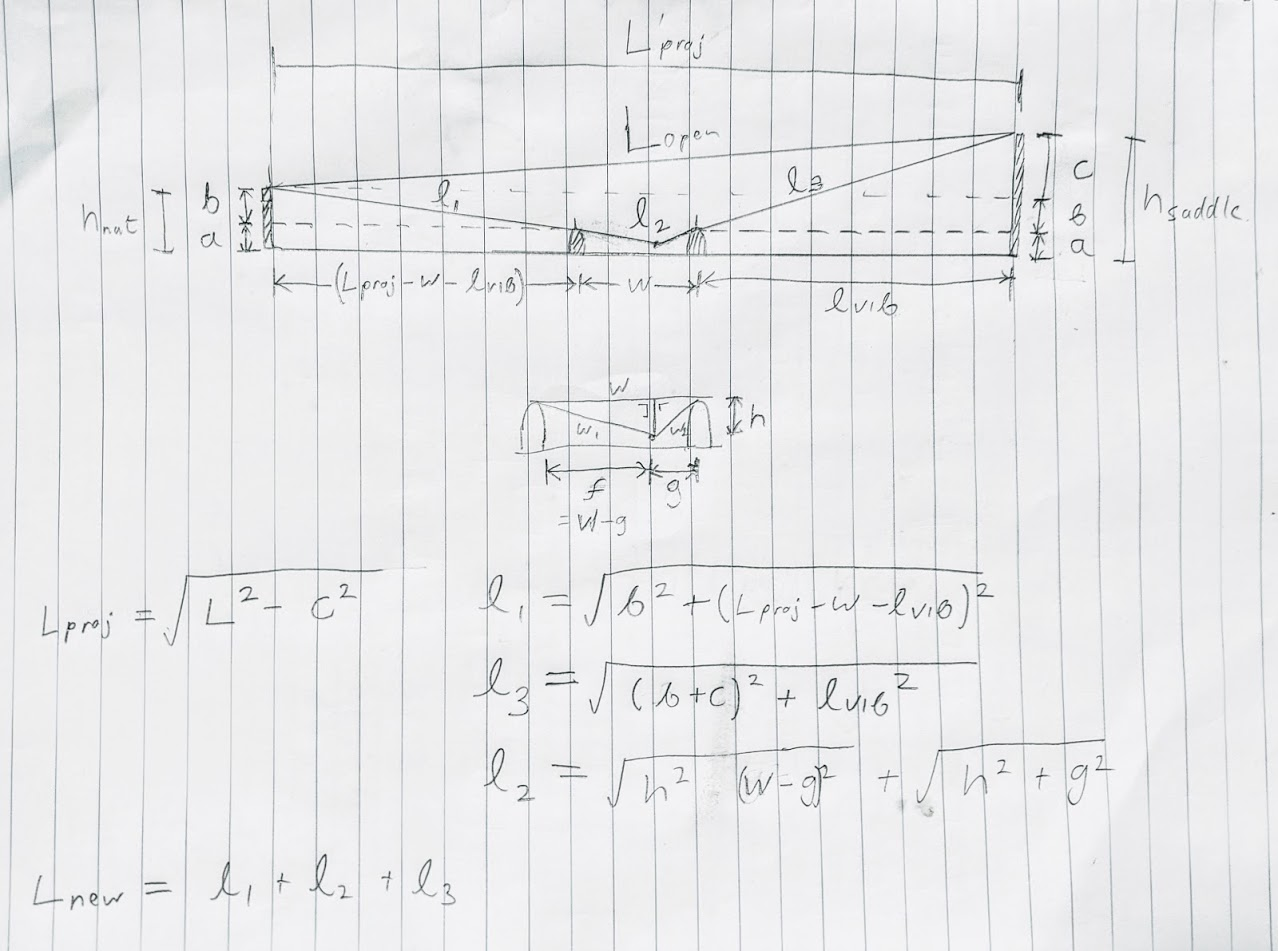

In [7]:
Image("Images/sharp_finger.jpeg")

In [8]:
def model2(vibeLenArr, actionNut=1.5/1000, actionFret12=3.5/1000, 
           fretHeight=1.0/1000, depressHeight=0.5/1000, depressMod=0.2, 
           verbose=False):
    """
    Return an array of total (i.e., open) string lengths 
    corresponding to the string being depressed behind each fret.
    """    
    
    # Calculate the slope of the open string and action at saddle
    x1 = vibeLenArr[12]
    x2 = vibeLenArr[0]
    y1 = actionFret12
    y2 = actionNut
    m = (y2 - y1) / (x2 - x1)
    actionSaddle = actionFret12 - m * vibeLenArr[12]
    
    # Intermediate variables
    a = fretHeight
    b = actionNut - fretHeight
    c = actionSaddle - actionNut
    
    # We assume that vibeLenArr contains only ideal, projectected lengths
    # i.e., already projected onto the fretboard coord system.
    # Need to calculate Lopen as the projection onto the string
    Lproj = vibeLenArr[0]
    Lopen = np.sqrt(vibeLenArr[0]**2.0 + c**2.0)
        
    # Calculate the fret width array [OK]
    fretWidthArr = np.zeros_like(vibeLenArr)
    fretWidthArr[1:] = -1 * np.diff(vibeLenArr)    
    fretWidthArr[-1] = np.nan
    
    # Calculate l1, the string length above the finger press.
    # At 1st fret l1 = 0 because there is no fret closer to nut.
    l1 = np.sqrt(b**2.0 + (Lproj - fretWidthArr - vibeLenArr)**2.0)
    l1[0:2] = 0
    
    # Calculate l3, the string length below the finger press
    # At nut (index=0) l3 = Lopen
    l3 = np.sqrt((b + c)**2.0 + vibeLenArr**2.0)
    l3[0] = Lopen
    
    # Calculate the depressHeight array, which becomes less as the
    # frets get closer together. The depressMod term decreases the
    # strength of the correction with fret-number, with 0 = light 
    # finger (less depression at higher frets) and 1 = heavy finger
    # (full depression at higher frets).
    depressHeightArr = np.ones_like(fretWidthArr) * depressHeight
    depressHeightArr[-1] = np.nan
    depressFrac = fretWidthArr/fretWidthArr[1]
    depressFrac += (1-depressFrac) * depressMod
    depressHeightArr *= depressFrac    
    
    # Calculate g, the offset from the fret
    gArr = fretWidthArr / 2
    
    # Calculate l2, the sharp finger deflection between frets
    l2 = (np.sqrt(depressHeightArr**2.0 + (fretWidthArr - gArr)**2.0) +
          np.sqrt(depressHeightArr**2.0 + gArr**2.0))
    l2[0] = 0
    
    # Calculate l2 at the 1st fret, which runs directly to the nut
    l2[1] = (np.sqrt((depressHeightArr[1] + b)**2.0 + (fretWidthArr[1] - gArr[1])**2.0) +
             np.sqrt(depressHeightArr[1]**2.0 + gArr[1]**2.0))
    
    # Deflected length: nut-to-finger + fingerWidth + fret-to-saddle
    # Set the nut to the open length and saddle to np.nan
    newLArr = l1 + l2 + l3
    newLArr[-1] = np.nan
        
    # Some feedback
    if verbose:
        print("Saddle Action = {:6.2f}".format(actionSaddle))
        print("Open Length   = {:6.2f}".format(Lopen))
    
    return newLArr

In [9]:
# Model 1
model1LArr_m = model1(vibeLenIdealArr_m, actionNut_m, actionFret12_m,
                      fingerWidth_m)

# Model 2
model2LArr_m = model2(vibeLenIdealArr_m, actionNut_m, actionFret12_m, 
                      fretHeight_m, depressHeight_m, depressMod)

Text(0,0.5,'$\\Delta L (mm)$')

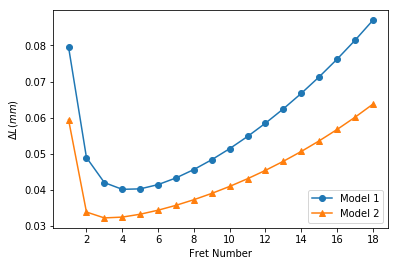

In [10]:
# Calculate the increase in length, delta_L
delta1L_m = model1LArr_m - model1LArr_m[0]
delta2L_m = model2LArr_m - model2LArr_m[0]

# Plot the length increase for a thin and normal finger
fretNumArr = np.arange(len(vibeLenIdealArr_m))
ax = plt.subplot(1, 1, 1)
ax.plot(fretNumArr[1:], delta1L_m[1:]*1000, marker="o", label="Model 1")
ax.plot(fretNumArr[1:], delta2L_m[1:]*1000, marker="^", label="Model 2")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
leg = ax.legend()
ax.set_xlabel("Fret Number")
ax.set_ylabel("$\Delta L (mm)$")